In [1]:
import os
import requests
import pandas as pd
from astropy.io import fits
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma
from scipy.optimize import minimize
from scipy.interpolate import RectBivariateSpline
import emcee
import corner
import scipy.io as sio
from ipywidgets import FloatProgress
from IPython.display import display
import time

import completeness as c

In [2]:
stellarCatalog = "../stellarCatalogs/dr25_stellar_supp_gaia_clean_GKM.txt"
pcCatalog = "koiCatalogs/dr25_GKM_PCs.csv"

period_rng = (10, 400)
n_period = 100
rp_rng = (4, 15)
n_rp = 100

# for quick tests
nWalkers = 8
nBurnin = 200
nMcmc = 1000
# for production runs
#nWalkers = 100
#nBurnin = 1000
#nMcmc = 2000

model = "constant period"
# which Radii lets you try with planet radii corrected for Gaia radii (whichRadii = "corrected")
# or with original KOI table planet radii (whichRadii = "kic")
whichRadii = "corrected"

In [3]:
# population inference functions
def lnlike(theta):
    pop = c.rateModel(period_grid, rp_grid, period_rng, rp_rng, theta, model) * summedCompleteness
    pop = 0.5 * (pop[:-1, :-1] + pop[1:, 1:])
    norm = np.sum(pop * vol)
    #print(norm)
    #print(np.sum(np.log(rateModel(koi_periods, koi_rps, period_rng, rp_rng, theta, model))))
    ll = np.sum(np.log(c.rateModel(koi_periods, koi_rps, period_rng, rp_rng, theta, model))) - norm
    return ll if np.isfinite(ll) else -np.inf

# The ln-probability function is just propotional to the ln-likelihood
# since we're assuming uniform priors.
def lnprob(theta):
    lp = c.lnPoisprior(theta, model)
    if not np.isfinite(lp):
        return -np.inf
    return lnlike(theta)

# The negative ln-likelihood is useful for optimization.
# Optimizers want to *minimize* your function.
def nll(theta):
    ll = lnlike(theta)
    return -ll if np.isfinite(ll) else 1e15

In [4]:
stellarTargets = pd.read_csv(stellarCatalog)
base_kois = pd.read_csv(pcCatalog)
m = (period_rng[0] <= base_kois.koi_period) & (base_kois.koi_period <= period_rng[1])
thisRadii = c.getRadii(base_kois, whichRadii)
m &= np.isfinite(thisRadii) & (rp_rng[0] <= thisRadii) & (thisRadii <= rp_rng[1])
    
kois = pd.DataFrame(base_kois[m])
allKois = kois

In [5]:
from random import sample
period_samp = sample(list(np.logspace(np.log10(period_rng[0]), np.log10(period_rng[1]), 1000)), 100)
radius_samp = sample(list(np.logspace(np.log10(rp_rng[0]), np.log10(rp_rng[1]), 1000)), 100)

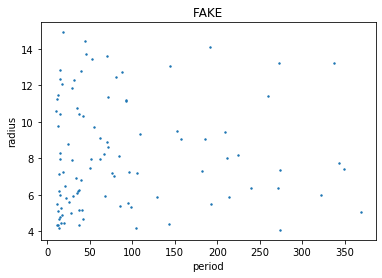

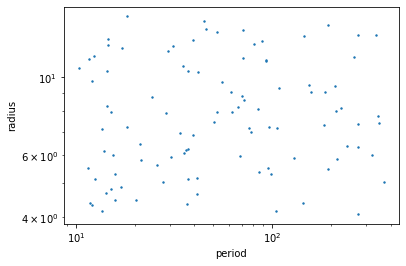

In [6]:
plt.figure()
plt.scatter(period_samp, radius_samp, s=2)
plt.title('FAKE')
#plt.ylim(0, 5)
plt.xlabel('period')
plt.ylabel('radius')

plt.figure()
plt.scatter(period_samp, radius_samp, s=2)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('period')
plt.ylabel('radius')
plt.show()

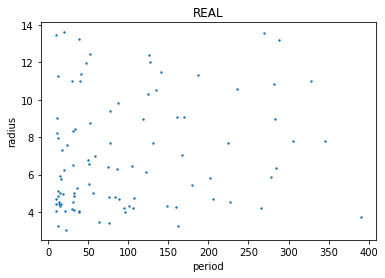

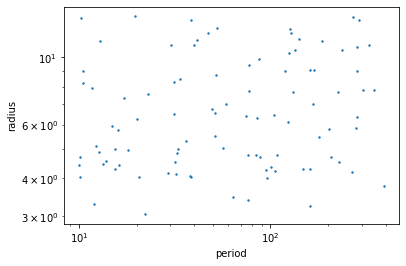

In [7]:
plt.figure()
plt.scatter(kois.koi_period, kois.koi_prad, s=2)
plt.title("REAL")
#plt.ylim(0, 5)
plt.xlabel('period')
plt.ylabel('radius')

plt.figure()
plt.scatter(kois.koi_period, kois.koi_prad, s=2)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('period')
plt.ylabel('radius')
plt.show()

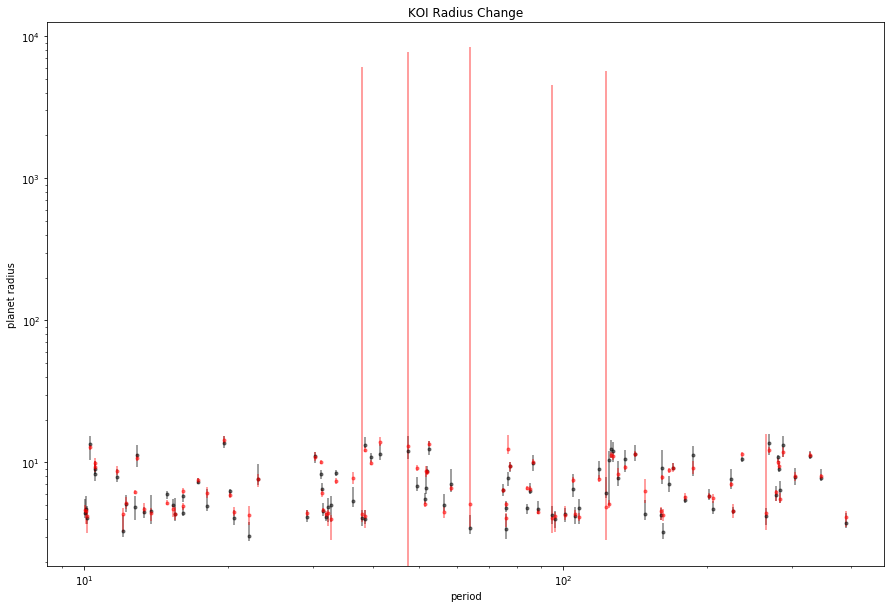

In [8]:
fig, ax = plt.subplots(figsize=(15,10))
ax.errorbar(kois.koi_period, kois.koi_prad, 
            yerr = [-kois.koi_prad_err2, kois.koi_prad_err1],
            fmt="k.", alpha = 0.5)
ax.errorbar(kois.koi_period, kois.corrected_prad, 
            yerr = [-kois.corrected_prad_err2, kois.corrected_prad_err1],
            fmt="r.", alpha = 0.5)

plt.xlabel("period")
plt.ylabel("planet radius")
plt.title("KOI Radius Change")
plt.yscale('log')
plt.xscale('log')
plt.show()

In [9]:
period = np.logspace(np.log10(period_rng[0]), np.log10(period_rng[1]), n_period)
rp = np.logspace(np.log10(rp_rng[0]), np.log10(rp_rng[1]), n_rp)
period_grid, rp_grid = np.meshgrid(period, rp, indexing="ij")
periodShape = period_grid.shape

In [10]:
inputgrid = "../completenessContours/out_sc0_GKM_baseline.fits.gz"

hdulist = fits.open(inputgrid)
cumulative_array = hdulist[0].data
kiclist = np.asarray(hdulist[1].data, dtype=np.int32)
probdet = np.transpose(cumulative_array[0])
probtot = np.transpose(cumulative_array[1])
probtr2d = np.transpose(cumulative_array[2])
prihdr = hdulist[0].header
min_comp_period = prihdr["MINPER"]
max_comp_period = prihdr["MAXPER"]
n_comp_period = prihdr["NPER"]
min_comp_rp = prihdr["MINRP"]
max_comp_rp = prihdr["MAXRP"]
n_comp_rp = prihdr["NRP"]
# print "KIC list length" + '{:6d}'.format(kiclist.size)
print(hdulist[0].header,)

period_want = np.logspace(np.log10(min_comp_period), np.log10(max_comp_period), n_comp_period)
rp_want = np.logspace(np.log10(min_comp_rp), np.log10(max_comp_rp), n_comp_rp)
period_want2d, rp_want2d = np.meshgrid(period_want, rp_want)

numCompVeInterp = RectBivariateSpline(period_want, rp_want, probtot)
numProbDetInterp = RectBivariateSpline(period_want, rp_want, probdet)
numProbTransit = RectBivariateSpline(period_want, rp_want, probtr2d)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                 2000                                                  NAXIS2  =                 3000                                                  NAXIS3  =                    3                                                  EXTEND  =                    T                                                  MINPER  =                 10.0                                                  MAXPER  =                400.0                                                  NPER    =                 2000                                                  MINRP   =                  4.0                                                  MAXRP   =                 15.0                                                  NRP     =                 3000          

In [11]:
summedCompleteness = numCompVeInterp(period, rp)
summedProbDet = numProbDetInterp(period, rp)
probTransit = numProbTransit(period, rp)

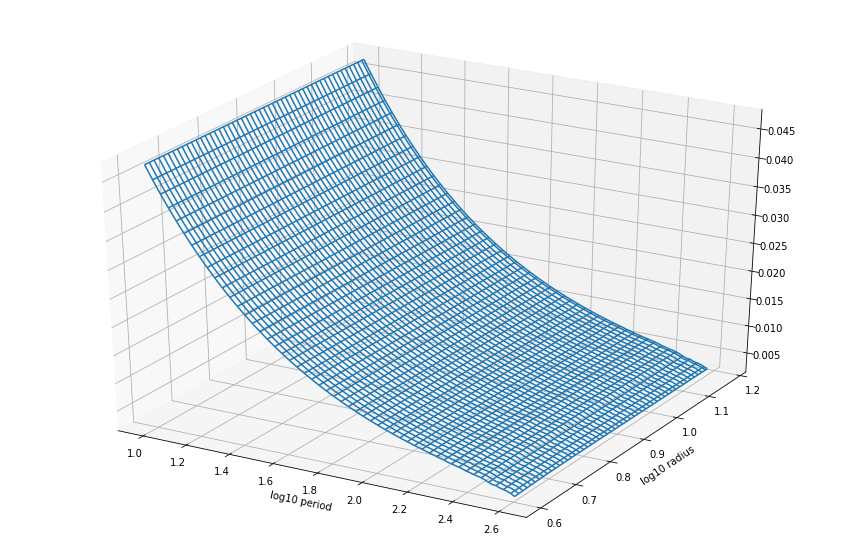

In [12]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')

logp = np.log10(period_grid)
logr = np.log10(rp_grid)

ax.plot_wireframe(logp, logr, summedCompleteness / kiclist.size, rstride=2, cstride=2)  
ax.set_xlabel('log10 period')
ax.set_ylabel('log10 radius')
plt.show()

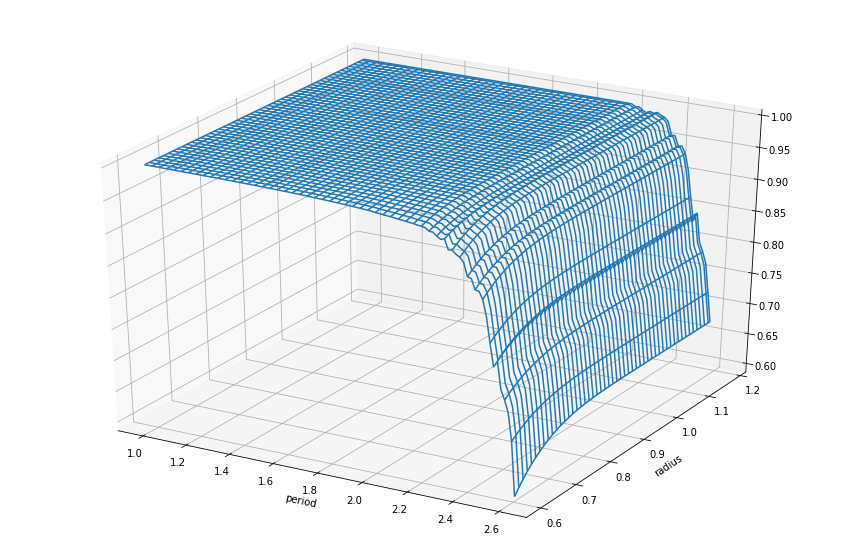

In [13]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(np.log10(period_grid), np.log10(rp_grid), summedProbDet/ kiclist.size, rstride=2, cstride=2)  
ax.set_xlabel('period')
ax.set_ylabel('radius')
plt.show()

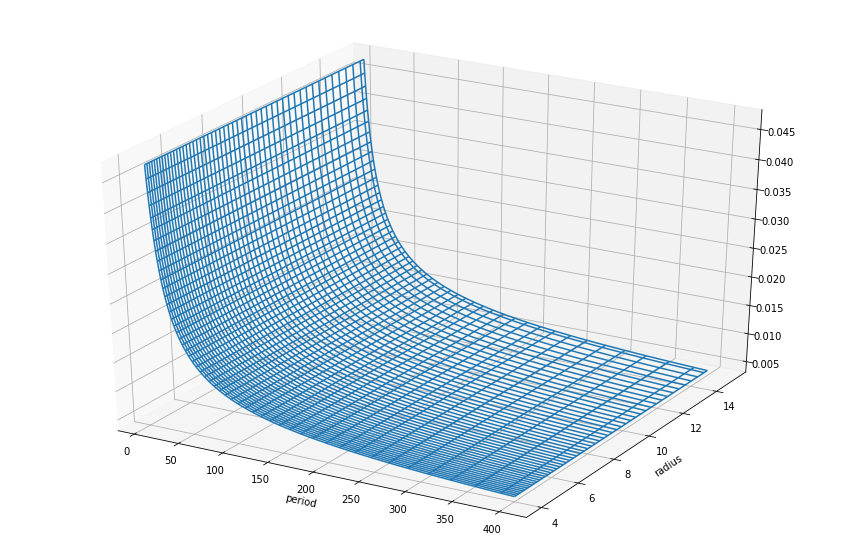

In [14]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(period_grid, rp_grid, probTransit / kiclist.size, rstride=2, cstride=2)  
ax.set_xlabel('period')
ax.set_ylabel('radius')
plt.show()

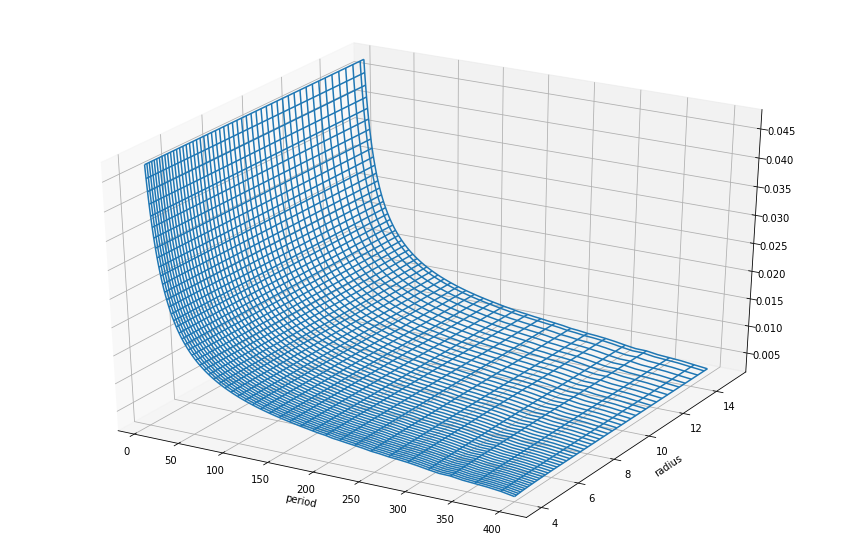

In [15]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(period_grid, rp_grid, (probTransit/ kiclist.size)*(summedProbDet/ kiclist.size), rstride=2, cstride=2)
ax.set_xlabel('period')
ax.set_ylabel('radius')
plt.show()

In [16]:
#plt.figure()
#plt.scatter(period_grid[:,1000], (probTransit[:,1000]/ kiclist.size)*(summedProbDet[:,1000]/ kiclist.size), s=1)
#plt.ylim(0, 0.012)

#plt.figure()
#plt.scatter(rp_grid[1000, :], (probTransit[1000, :]/ kiclist.size)*(summedProbDet[1000, :]/ kiclist.size), s=1)
#plt.ylim(0.0135, 0.0145)

In [17]:
(probTransit/ kiclist.size)*(summedProbDet/ kiclist.size)

array([[0.04736632, 0.04736708, 0.04736774, ..., 0.04737064, 0.04737064,
        0.04737064],
       [0.04620384, 0.0462046 , 0.04620535, ..., 0.0462084 , 0.0462084 ,
        0.0462084 ],
       [0.04506987, 0.0450706 , 0.04507132, ..., 0.04507468, 0.04507468,
        0.04507468],
       ...,
       [0.00308507, 0.00309805, 0.00311035, ..., 0.00327404, 0.00327404,
        0.00327404],
       [0.00282756, 0.00283957, 0.00285112, ..., 0.00300339, 0.00300339,
        0.00300339],
       [0.00240598, 0.00242669, 0.00244649, ..., 0.00273733, 0.00273733,
        0.00273733]])

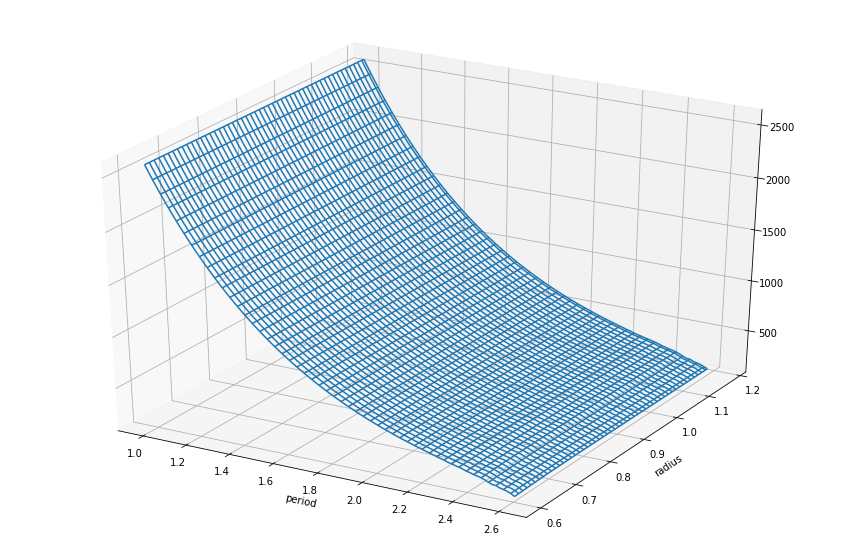

In [18]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(np.log10(period_grid), np.log10(rp_grid), (probTransit*summedProbDet)/ kiclist.size, rstride=2, cstride=2)  
ax.set_xlabel('period')
ax.set_ylabel('radius')
plt.show()

In [126]:
# population analysis functions modified from Daniel Foreman Mackey's https://dfm.io/posts/exopop/
# We'll reuse these functions to plot all of our results.
def make_plot(pop_comp, x0, x, y, ax, color):
    pop = 0.5 * (pop_comp[:, 1:, :] + pop_comp[:, :-1, :])
    print('pop: ' +  str(pop.shape))
    pop = np.sum(pop * np.diff(y)[None, :, None], axis=1)
    print('pop: ' +  str(pop.shape))
    print('diff: ' +  str(np.diff(x).shape))
    print('x: ' +  str(x.shape))
    print(pop[0])
    a, b, c, d, e = np.percentile(pop * np.diff(x)[0], [2.5, 16, 50, 84, 97.5], axis=0)
    #print(c)
    
    #ax.fill_between(x0, a, e, color="k", alpha=0.1, edgecolor="none")
    #ax.fill_between(x0, b, d, color="k", alpha=0.3, edgecolor="none")
    ax.plot(x0, c, color, lw=1)
    return(x0, c)

def plot_results(samples):
    # Loop through the samples and compute the list of population models.
    samples = np.atleast_2d(samples)
    pop = np.empty((len(samples), period_grid.shape[0], period_grid.shape[1]))
    gamma_earth = np.empty((len(samples)))

    for i, p in enumerate(samples):
        pop[i] = c.rateModel(period_grid, rp_grid, period_rng, rp_rng, p, model)
        gamma_earth[i] = c.rateModel(365.25, 1.0, period_rng, rp_rng, p, model) * 365.
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    fig.subplots_adjust(wspace=0.4, hspace=0.4)
    
    # Integrate over radius.
    dx = 0.25
    rad_bin = np.arange(rp_rng[0], rp_rng[1] + dx, dx)
    #rad_bin = np.logspace(np.log10(rp_rng[0]), np.log10(rp_rng[1]), 20)
    rad_n, _ = np.histogram(koi_rps, rad_bin)
    
    fsize = 18
    # Plot the observed radius distribution.
    ax = axes[0, 0]
    print('radius')
    xxo_rad, cco_rad = make_plot(pop * summedCompleteness[None, :, :], rp, rad_bin, period, ax, color='r')
    ax.errorbar(0.5*(rad_bin[:-1]+rad_bin[1:]), rad_n, yerr=np.sqrt(rad_n), fmt=".k",
                capsize=0, ecolor="pink")
    #ax.set_xlim(rp_rng[0], rp_rng[1])
    ax.set_xlabel("$R_p\,[R_\oplus]$", fontsize = fsize)
    ax.set_ylabel("# of detected planets", fontsize = fsize)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    # Plot the true radius distribution.
    ax = axes[0, 1]
    xxt_rad, cct_rad = make_plot(pop, rp, rad_bin, period, ax, color='b')
    ax.set_xlabel("$R_p\,[R_\oplus]$", fontsize = fsize)
    ax.set_ylabel("$\mathrm{d}N / \mathrm{d}R$", fontsize = fsize)
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    
    # Integrate over period.
    dx = 5
    per_bin = np.arange(period_rng[0], period_rng[1] + dx, dx)
    #per_bin = np.logspace(np.log10(period_rng[0]), np.log10(period_rng[1]), 10)
    per_n, _ = np.histogram(koi_periods, per_bin)
    
    # Plot the observed period distribution.
    ax = axes[1, 0]
    print('period')
    xxo_p, cco_p = make_plot(np.swapaxes(pop * summedCompleteness[None, :, :], 1, 2), 
                             period, per_bin, rp, ax, color='g')
    ax.errorbar(0.5*(per_bin[:-1]+per_bin[1:]), per_n, yerr=np.sqrt(per_n), fmt=".y",
                capsize=0, ecolor="c")
    ax.set_xlabel("$P\,[\mathrm{days}]$", fontsize = fsize)
    ax.set_ylabel("# of detected planets", fontsize = fsize)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    # Plot the true period distribution.
    ax = axes[1, 1]
    xxt_p, cct_p = make_plot(np.swapaxes(pop, 1, 2), period, per_bin, rp, ax, color='m')
    ax.set_xlabel("$P\,[\mathrm{days}]$", fontsize = fsize)
    ax.set_ylabel("$\mathrm{d}N / \mathrm{d}P$", fontsize = fsize)
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    
    ###########################################
    pop_comp = np.swapaxes(pop * summedCompleteness[None, :, :], 1, 2)
    x0 = period.copy()
    x = per_bin.copy()
    y = rp.copy()
    color = 'g'
    u = np.linspace(period_rng[0], period_rng[1], 100)
    v = np.linspace(rp_rng[0], rp_rng[1], 100)

    pop = 0.5 * (pop_comp[:, 1:] + pop_comp[:, :-1])
    #print(pop)
    #print(np.diff(y))
    pop = np.sum((pop * np.diff(y)[None, :, None]), axis=1)
    #print(pop * np.diff(y)[None, :, None])
    #print(pop * np.diff(x)[0])
    #print(pop)
    a, b, ce, d, e = np.percentile((pop * np.diff(x)[0]), [2.5, 16, 50, 84, 97.5], axis=0)
    
    plt.figure()
    #ax.fill_between(x0, a, e, color="k", alpha=0.1, edgecolor="none")
    #ax.fill_between(x0, b, d, color="k", alpha=0.3, edgecolor="none")
    plt.plot(x0, ce, color, lw=1)
    
    plt.show()
             
    return gamma_earth, fig

Compute a basic occurrence rate without reliability

/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


[ 0.20623578 -2.06350888]
radius
pop: (1, 99, 100)
pop: (1, 100)
diff: (44,)
x: (45,)
[33.27213365 32.41559518 31.57820132 30.75961855 29.95966136 29.1781995
 28.41492878 27.66960497 26.942019   26.23191406 25.53897759 24.86291541
 24.20348133 23.56038984 22.93338097 22.32204294 21.72612175 21.14531308
 20.57929216 20.02773713 19.4903415  18.96678779 18.4567961  17.96004172
 17.47625149 17.00514256 16.54640248 16.09974375 15.66486103 15.24148767
 14.8293412  14.42813284 14.03759924 13.65747125 13.28750267 12.92742753
 12.5770005  12.23598376 11.90413174 11.58120143 11.26696676 10.96120333
 10.66368979 10.37421166 10.09255275  9.81850517  9.55187335  9.29246517
  9.04008145  8.79453658  8.55564502  8.32323111  8.09712     7.8771427
  7.66313623  7.45493896  7.25239472  7.05534843  6.86365154  6.67716206
  6.49573703  6.3192379   6.14753339  5.98049182  5.81798823  5.65989804
  5.50610293  5.35648602  5.21093379  5.06933606  4.93158574  4.79757808
  4.66721152  4.54038725  4.41700883  4.

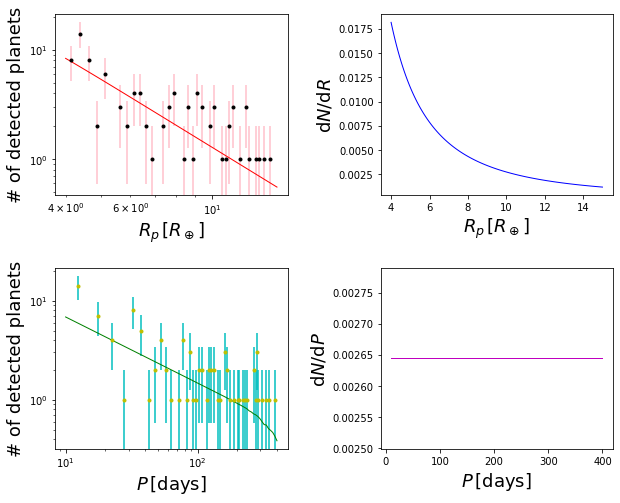

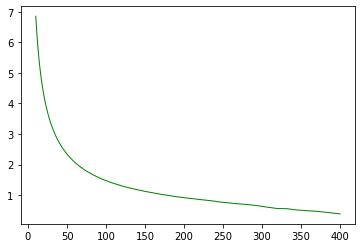

In [127]:
kois = allKois

if model == "dualPowerLaw":
    bounds = [(0, 8), (-1, 1), (-5, 5)]
    #bounds = [(0, 8), (0, 0), (-5, 5)]
elif model == "constant period":
    bounds = [(0, 8), (-5, 5)]
else:
    bounds = [(0, 8)]
    
# The ln-likelihood function given at the top of this post.
koi_periods = kois.koi_period
koi_rps = c.getRadii(kois, whichRadii)

vol = np.diff(period_grid, axis=0)[:, :-1] * np.diff(rp_grid, axis=1)[:-1, :]

theta_0 = c.initRateModel(model)
r = minimize(nll, theta_0, method="L-BFGS-B", bounds=bounds)
print(r.x)
ge, fig = plot_results(r.x)
#[ 0.88074391 -0.50150404  0.11076642]

In [132]:
x = np.array([[[1, 2, 3],
     [2, 4, 6]]])
y = np.array([[[5],
     [10]]])

print(x[:, 1:])
print(x[:, :-1])
print(0.5 * (x[:, 1:] + x[:, :-1]))
print(x*y)
print(np.sum(x*y, axis=1))
x[:-1, :, :]

[[[2 4 6]]]
[[[1 2 3]]]
[[[1.5 3.  4.5]]]
[[[ 5 10 15]
  [20 40 60]]]
[[25 50 75]]


array([], shape=(0, 2, 3), dtype=int64)

In [ ]:
ndim, nwalkers = len(r.x), nWalkers
pos = [r.x + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]
#print(pos)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=8)
#print(sampler)

# Burn in.
pos, _, _ = sampler.run_mcmc(pos, nBurnin)
sampler.reset()

# Production.
start_time = time.time()
pos, _, _ = sampler.run_mcmc(pos, nMcmc)
print("--- %s seconds ---" % (time.time() - start_time))

samples_noreliability = sampler.flatchain

In [ ]:
corner.corner(samples_noreliability, labels=c.getModelLabels(model), label_kwargs = {"fontsize": 32})

gamma_earth_no_reliability, fig = plot_results(samples_noreliability)

Compute an occurrence rate with reliability

In [ ]:
#break
nTrials = 100

f = FloatProgress(min=0, max=nTrials)
display(f)

allKois = kois
for mCount in range(nTrials):
    # randomly select kois
    
    koiSelect = (np.random.rand(len(allKois)) < allKois.totalReliability)
    kois = allKois[koiSelect]
    
    koi_periods = np.array(kois.koi_period)
    koi_rps = np.array(c.getRadii(kois, whichRadii))

    theta_0 = c.initRateModel(model)
    r = minimize(nll, theta_0, method="L-BFGS-B", bounds=bounds)

    ndim, nwalkers = len(r.x), 2*len(r.x)
    pos = [r.x + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

    # Burn in.
    pos, _, _ = sampler.run_mcmc(pos, 200)
    sampler.reset()

    # Production.
    pos, _, _ = sampler.run_mcmc(pos, 1000)

    samples = sampler.flatchain   
    if mCount == 0:
        allSamples = samples[0:-1:10,:]
    else:
        allSamples = np.concatenate((allSamples, samples[0:-1:10,:]))
    
    f.value += 1

In [ ]:
corner.corner(allSamples, labels=c.getModelLabels(model), label_kwargs = {"fontsize": 32})

In [ ]:
modelLabels = c.getModelLabels(model)
for i in range(0,ndim):
    print("MCMC no reliability " + modelLabels[i] + "=" + c.printMedianAndErrorbars(samples_noreliability[:,i]))
for i in range(0,ndim):
    print("MCMC with reliability " + modelLabels[i] + "=" + c.printMedianAndErrorbars(allSamples[:,i]))

In [ ]:
allSamples

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
rateGrid = c.rateModel(period_grid, rp_grid, period_rng, rp_rng, np.median(allSamples, 0), model)
CS = ax.contour(period_grid, rp_grid, rateGrid)
ax.clabel(CS, inline=1, fontsize=10)
plt.yscale('log')
plt.xscale('log')
#plt.ylim(0, 10)
#plt.xlim(0, 500)
plt.xlabel("Period", fontsize = 18)
plt.ylabel("Radius", fontsize = 18)
plt.title("Occurrence Rate Fit", fontsize = 24)
plt.show()